In [1]:
import joblib
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import numpy as np

In [2]:
def get_config(is_jaguar=True):
    """
        histograms_path = Set the path to store the histograms
        model_path = Set the path to load the BDT to clean the data
        response_matrix_path = Set the path to read the response matrix
    """
    # histograms configuration
    config = {
        "hist" : {
            "nbins" : 50,
            "rmin" : 0.2,
            "rmax" : 1.8
        }
    }
    if is_jaguar:
        print("Loading configuration to run in Jaguar")
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/data40/*.root",
            "workers" : 45,
            "step_size" : "500 MB"
        }
        config["model_path"] = "/home/cpegueros/bdt/gradient_1627111793.joblib"
        config["histograms_path"] = "/home/cpegueros/thesis/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/cpegueros/thesis/tau2pipi0nu_response_matrix.pkl"
    else:
        print("Loading configuration to run in local. No data will be available.")
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None
        }
        config["model_path"] = "/home/peguerosdc/development/thesis/data/gradient_1627111793.joblib"
        config["histograms_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_response_matrix.pkl"
    return config

In [3]:
config = get_config(is_jaguar=True)

Loading configuration to run in Jaguar


In [27]:
# Amount of bins and histogram limits
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]
branches = ["neutral_sig_px", "neutral_sig_py", "neutral_sig_pz", "neutral_sig_E"]
branches += ["neutral_sig_mcPX", "neutral_sig_mcPY", "neutral_sig_mcPZ", "neutral_sig_mcE"]
branches += ["track_sig_px", "track_sig_py", "track_sig_pz", "track_sig_E"]
branches += ["track_sig_mcPX", "track_sig_mcPY", "track_sig_mcPZ", "track_sig_mcE"]

# Histogram to store the raw data
data_tau_M = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_tau_M_mc = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_tau_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_tau_sig_matchedMC_InvM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_pipi0_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_pipi0_invM_matchedMC = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

In [28]:
for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches, step_size=config["data"]["step_size"], num_workers=config["data"]["workers"]):
    # Para la invm del tau
    # data_tau_invM.fill( df.tau_sig_InvM )
    # data_tau_M.fill( df.tau_sig_M )
    # data_tau_M_mc.fill( (df.tau_sig_mcE**2 - df.tau_sig_mcP**2)**(1/2) )
    # data_tau_sig_matchedMC_InvM.fill( df.tau_sig_matchedMC_InvM )
    # Para el pipi0
    data_pipi0_invM.fill( np.sqrt(
        (df.neutral_sig_E + df.track_sig_E)**2
        - (df.neutral_sig_px + df.track_sig_px)**2 - (df.neutral_sig_py + df.track_sig_py)**2 - (df.neutral_sig_pz + df.track_sig_pz)**2)
    )
    data_pipi0_invM_matchedMC.fill( np.sqrt(
        (df.neutral_sig_mcE + df.track_sig_mcE)**2
        - (df.neutral_sig_mcPX + df.track_sig_mcPX)**2 - (df.neutral_sig_mcPY + df.track_sig_mcPY)**2 - (df.neutral_sig_mcPZ + df.track_sig_mcPZ)**2)
    )


/home/cpegueros/venv/lib/python3.6/site-packages/awkward/_connect/_numpy.py:161: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs


Text(0.5, 1.0, '$m = \\sqrt{E^2 - px^2 - py^2 - pz^2}$')

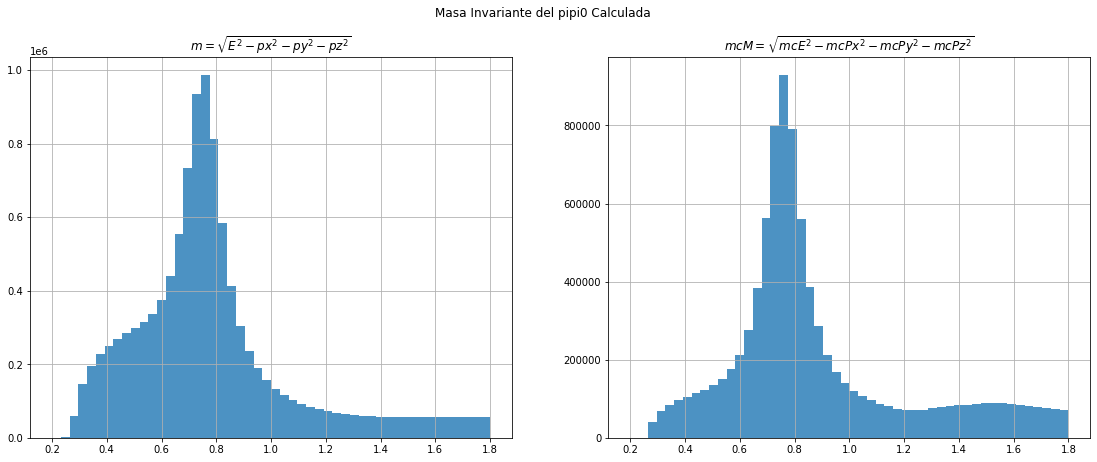

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle("Masa Invariante del pipi0 Calculada")
# con mc
ax = axs[1]
ax.grid()
ax.bar(data_pipi0_invM_matchedMC.axes[0].centers, data_pipi0_invM_matchedMC.view(), width=data_pipi0_invM_matchedMC.axes[0].widths, label="calculadoMC", alpha=0.8)
ax.set_title("$mcM = \sqrt{mcE^2 - mcPx^2 - mcPy^2 - mcPz^2}$")
# para el pipi0
ax = axs[0]
ax.grid()
ax.bar(data_pipi0_invM.axes[0].centers, data_pipi0_invM.view(), width=data_pipi0_invM.axes[0].widths, label="calculado", alpha=0.8)
ax.set_title("$m = \sqrt{E^2 - px^2 - py^2 - pz^2}$")


--------

Text(0.5, 1.0, 'matchedMC(tau_sig_InvM)')

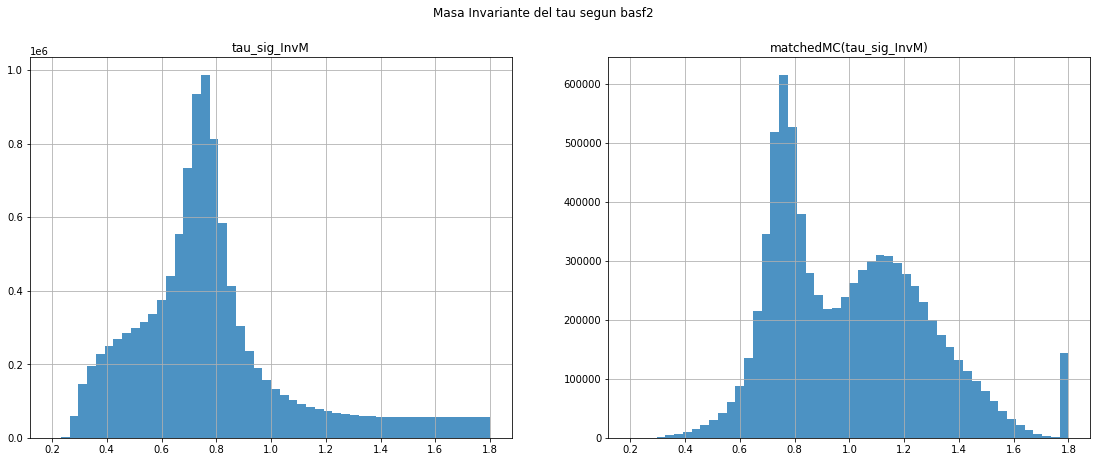

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle("Masa Invariante del tau segun basf2")
# con mc
ax = axs[0]
ax.grid()
ax.bar(data_tau_invM.axes[0].centers, data_tau_invM.view(), width=data_tau_invM.axes[0].widths, label="calculadoMC", alpha=0.8)
ax.set_title("tau_sig_InvM")
# para el pipi0
ax = axs[1]
ax.grid()
ax.bar(data_tau_sig_matchedMC_InvM.axes[0].centers, data_tau_sig_matchedMC_InvM.view(), width=data_tau_sig_matchedMC_InvM.axes[0].widths, label="calculado", alpha=0.8)
ax.set_title("matchedMC(tau_sig_InvM)")

Text(0.5, 1.0, '$s = E^2 - P^2$')

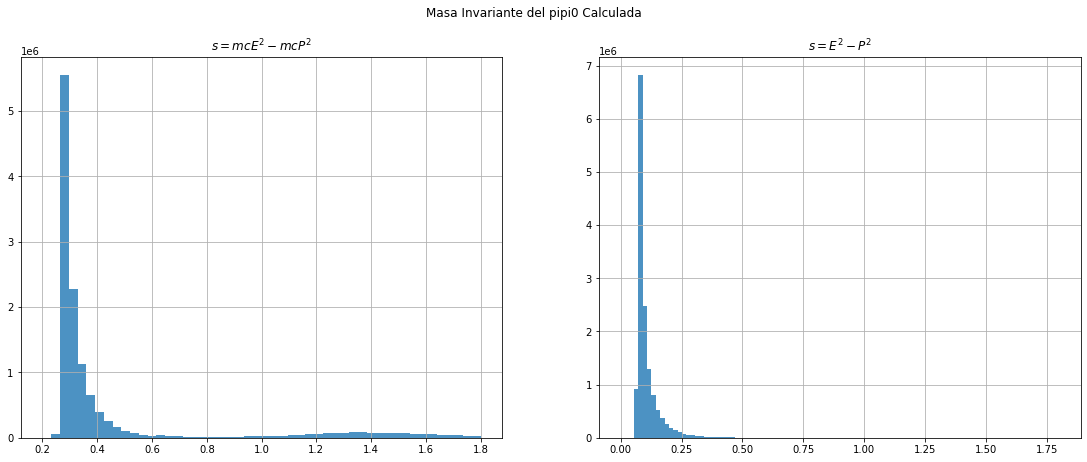

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle("Masa Invariante del pipi0 Calculada")
# con mc
ax = axs[0]
ax.grid()
ax.bar(data_pipi0_invM_matchedMC.axes[0].centers, data_pipi0_invM_matchedMC.view(), width=data_pipi0_invM_matchedMC.axes[0].widths, label="calculadoMC", alpha=0.8)
ax.set_title("$s = mcE^2 - mcP^2$")
# para el pipi0
ax = axs[1]
ax.grid()
ax.bar(data_pipi0_invM.axes[0].centers, data_pipi0_invM.view(), width=data_pipi0_invM.axes[0].widths, label="calculado", alpha=0.8)
ax.set_title("$s = E^2 - P^2$")


Text(0.5, 1.0, '$\\sqrt{mcE^2 - mcP^2}$')

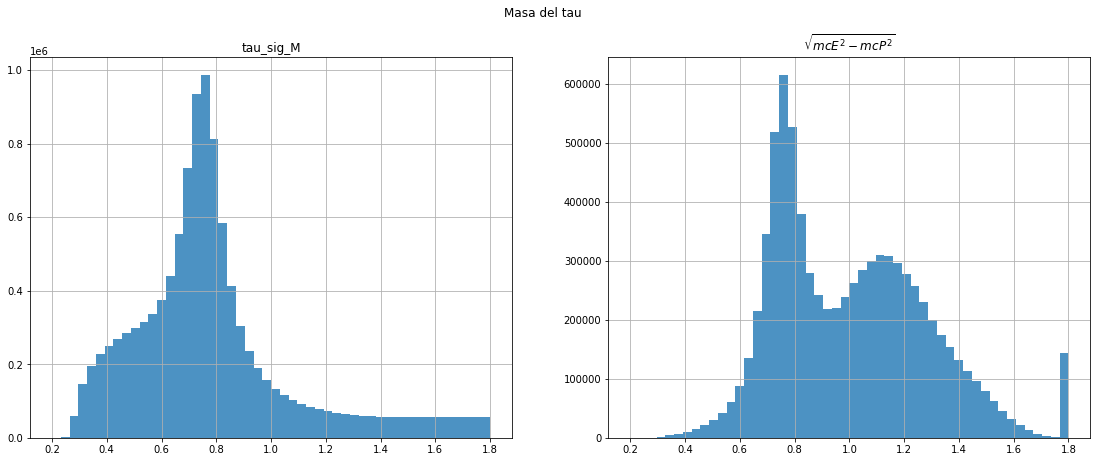

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle("Masa del tau")
# a nivel reconstruccion
ax = axs[0]
ax.grid()
ax.bar(data_tau_M.axes[0].centers, data_tau_M.view(), width=data_tau_M.axes[0].widths, label="calculadoMC", alpha=0.8)
ax.set_title("tau_sig_M")
# a nivel generacion pero calculada
ax = axs[1]
ax.grid()
ax.bar(data_tau_M_mc.axes[0].centers, data_tau_M_mc.view(), width=data_tau_M_mc.axes[0].widths, label="calculado", alpha=0.8)
ax.set_title("$\sqrt{mcE^2 - mcP^2}$")